In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase


Using TensorFlow backend.


## Load data

In [3]:
df_tsfresh = pd.read_pickle(f'../data/processed/train_test_tsfresh.pkl').reset_index(level = 0)
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')

#df_flat = df_tsfresh.pivot(df_tsfresh)
#df_flat.columns = ['_'.join(col).strip() for col in df_flat.columns.values]


# Build a ML model

In [52]:
from sklearn.model_selection import TimeSeriesSplit,ParameterGrid
cv = TimeSeriesSplit(n_splits=8)

def train_model(X, y, folds, model=None,score = mase,params = None):
    import time
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        m = model(X_train, y_train,X_valid,y_valid,params = params)
        score_val = m.evaluate(X_val = X_valid,y_val = y_valid)
        print(f'Fold {fold_n}. Score: {score_val:.4f}.')
        print('')
        scores.append(score_val)
    print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    mu = np.mean(scores)
    sd = np.std(scores)
    return scores,mu,sd,m


### Start with XGBoost


XGboost, 2016 data

In [53]:
# Make a search net:
# param_grids = {'max_depth':[18],
#                #'max_leaves':[255,511,1023,4095,8100],
#                'subsample':[0.05],
#                'colsample_bytree':[0.8],
#                'gamma':[1e1]  
# }
# default = {'eta': 0.1,
#                        'objective': 'reg:linear',
#                        "early_stopping_rounds": 200,
#               'verbose_eval':4000,
#               'silent':True,
#           'n_thread':-1,
#           "num_round":550}
default = {"n_jobs":4}
param_grids = {'n_neighbors':[5,10,15],
               'weights':['uniform'],
                'p':[2]}

grids = ParameterGrid(param_grids)
len(grids)
# params = {'nthread': -1,
#                       'max_depth': 10,
#                       'eta': 0.1,
#                       'objective': 'reg:linear',
#                       'colsample_bytree': 0.5,
#                       'subsample': 0.3,'silent':True,"num_round":200,
#                       "early_stopping_rounds": 100,
#               "max_leaves":d,
#              'verbose_eval':4000,
#              'silent':True}


3

In [56]:
from tqdm import trange
cv = TimeSeriesSplit(n_splits=5)
#orig_cols = data_dict[2016]['X_train'].columns

year = 2017
X = data_dict[year]['X_train']
y = data_dict[year]['y_train']


print(f'X_train shape: {X.shape}, y_train: {y.shape}')

inds = (X['rougher.input.feed_zn'] >0.5).index
inds_y =  (y[y['rougher.output.recovery']>5]).index
inds_year = X.index[X.index.year == year]

inds_common = inds_y.intersection(inds).intersection(inds_year)

y = y.loc[inds_common,'rougher.output.recovery']
X = X.loc[inds_common,]
print(f'X_train shape: {X.shape}, y_train: {y.shape}')

mus = []
sds=[]
grids_full=[]

for i in trange(len(grids)):
    g = grids[i]
    g ={**g,**default}
    grids_full.append(g)
    scores,mu,sd,m= train_model(X,y,cv,model = KNN,params = g);
    mus.append(mu)
    sds.append(sd)

# model = XGBoost(X_train,y_train,X_test,y_test,params = {'nthread': -1,
#                  'max_depth': 10,
#                  'eta': 0.1,
#                  'objective': 'reg:linear',
#                  'colsample_bytree': 0.01,
#                  'subsample': 0.1,'silent':True},num_round = 3000,esr = 200)



X_train shape: (5832, 65), y_train: (5832, 2)
X_train shape: (4951, 65), y_train: (4951,)


  0%|                                                                              | 0/3 [00:00<?, ?it/s]

Fold 0 started at Wed Feb 13 16:29:33 2019
Result on validation data:  18.363814256726485
Fold 0. Score: 18.3638.

Fold 1 started at Wed Feb 13 16:29:33 2019
Result on validation data:  7.375867676506025
Fold 1. Score: 7.3759.

Fold 2 started at Wed Feb 13 16:29:33 2019
Result on validation data:  5.7745524419751435
Fold 2. Score: 5.7746.

Fold 3 started at Wed Feb 13 16:29:34 2019
Result on validation data:  5.581315847196919
Fold 3. Score: 5.5813.

Fold 4 started at Wed Feb 13 16:29:34 2019
Result on validation data:  5.254759565110153
Fold 4. Score: 5.2548.

CV mean score: 8.4701, std: 5.0006.


 33%|███████████████████████▎                                              | 1/3 [00:01<00:02,  1.30s/it]

Fold 0 started at Wed Feb 13 16:29:34 2019
Result on validation data:  21.669878642521397
Fold 0. Score: 21.6699.

Fold 1 started at Wed Feb 13 16:29:34 2019
Result on validation data:  7.82023771599463
Fold 1. Score: 7.8202.

Fold 2 started at Wed Feb 13 16:29:35 2019
Result on validation data:  6.771432365181639
Fold 2. Score: 6.7714.

Fold 3 started at Wed Feb 13 16:29:35 2019
Result on validation data:  6.018114203882582
Fold 3. Score: 6.0181.

Fold 4 started at Wed Feb 13 16:29:35 2019
Result on validation data:  6.226495301090821
Fold 4. Score: 6.2265.

CV mean score: 9.7012, std: 6.0168.


 67%|██████████████████████████████████████████████▋                       | 2/3 [00:02<00:01,  1.29s/it]

Fold 0 started at Wed Feb 13 16:29:35 2019
Result on validation data:  20.007771377371686
Fold 0. Score: 20.0078.

Fold 1 started at Wed Feb 13 16:29:36 2019
Result on validation data:  8.10069401620639
Fold 1. Score: 8.1007.

Fold 2 started at Wed Feb 13 16:29:36 2019
Result on validation data:  7.920236000403081
Fold 2. Score: 7.9202.

Fold 3 started at Wed Feb 13 16:29:36 2019
Result on validation data:  6.549495876587346
Fold 3. Score: 6.5495.

Fold 4 started at Wed Feb 13 16:29:36 2019
Result on validation data:  7.400261900231635
Fold 4. Score: 7.4003.

CV mean score: 9.9957, std: 5.0349.


100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


[Text(0, 0, "{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}"),
 Text(0, 0, "{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}"),
 Text(0, 0, "{'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}")]

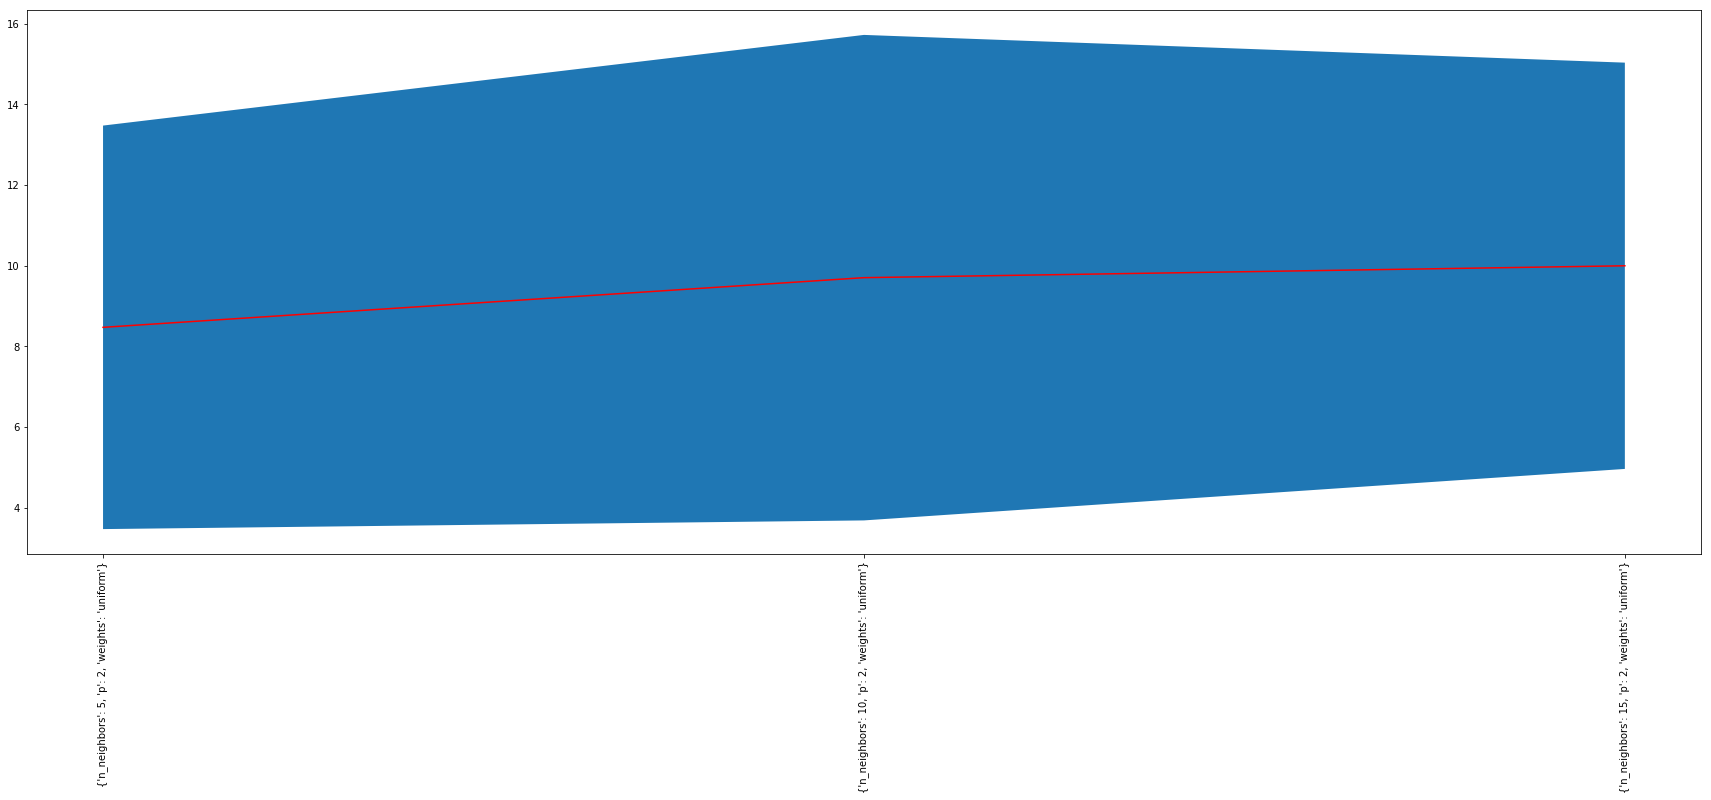

In [61]:
mus = np.array(mus)
sds = np.array(sds)
fig,ax = plt.subplots(figsize = (30,10))
ax.fill_between(np.arange(len(grids)),y1 = mus-sds,y2=mus+sds)
ax.plot(np.arange(len(grids)),mus,'-r')
labs = [str(g) for g in grids]
ax.set_xticks(np.arange(len(grids)))
ax.set_xticklabels(labs,rotation = 90)

In [10]:
id_grid = np.argmin(mus)
grid_best = {**grids[id_grid],**default}
print(f'Best score: {mus[id_grid]} +- {sds[id_grid]} at grid = {grid_best}')

Best score: 8.470061957502946 +- 5.000647773950758 at grid = {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'n_jobs': 4}


In [108]:
import xgboost
import pickle
with open('../results/qrf_final.output.recovery_2017__1.pkl','rb') as f:
    rf = pickle.load(f)
    
feat_df_rf = pd.DataFrame(data={'variable':X_test.columns,'value':rf.feature_importances_}).sort_values('value')
#fig,ax = plt.subplots(figsize = (20,30))
#sns.barplot(data = feat_df_rf,y='variable',x='value',ax =ax)
feat_df_rf.head(60)#.variable.to_list()


,variable,value
60,month_sin,0.000350
63,weekofyear_sin,0.002970
57,dow_cos,0.003098
54,hour_cos,0.005148
53,hour_sin,0.005203
5,primary_cleaner.state.floatbank8_a_level,0.005319
23,rougher.state.floatbank10_a_level,0.005331
51,secondary_cleaner.state.floatbank6_a_level,0.005502
55,dow,0.005569
33,rougher.state.floatbank10_f_level,0.005733


In [11]:
from sklearn.ensemble import RandomForestRegressor
from src.models.model import mase

rf = RandomForestRegressor(n_estimators = 50,max_depth = 10,n_jobs=-1,verbose = 1,random_state=123)
rf.fit(X,y)
#score = mase(y_test,rf.predict(X_test))
#print(f'Score valid = {score}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


NameError: name 'y_test' is not defined

# Build on raw data

In [13]:
import seaborn as sns
from mlxtend.evaluate import feature_importance_permutation
from sklearn.metrics import make_scorer
from sklearn.model_selection import permutation_test_score
#imp_vals, imp_all = feature_importance_permutation(predict_method=m.guess, X=X, y=y.values, metric='r2', num_rounds=3,  seed=1)
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1,cv = cv,n_iter = 3).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0

Weight,Feature
0.1386 ± 0.3203,rougher.input.feed_fe
0.1367 ± 0.1696,rougher.input.feed_zn
0.0550 ± 0.1883,secondary_cleaner.state.floatbank5_a_air
0.0405 ± 0.2608,primary_cleaner.input.copper_sulfate
0.0263 ± 0.0751,rougher.input.feed_sol
0.0254 ± 0.0744,primary_cleaner.state.floatbank8_a_air
0.0251 ± 0.0534,rougher.input.floatbank11_xanthate
0.0236 ± 0.0637,rougher.input.feed_pb
0.0141 ± 0.0313,primary_cleaner.state.floatbank8_b_air
0.0131 ± 0.0479,primary_cleaner.input.depressant


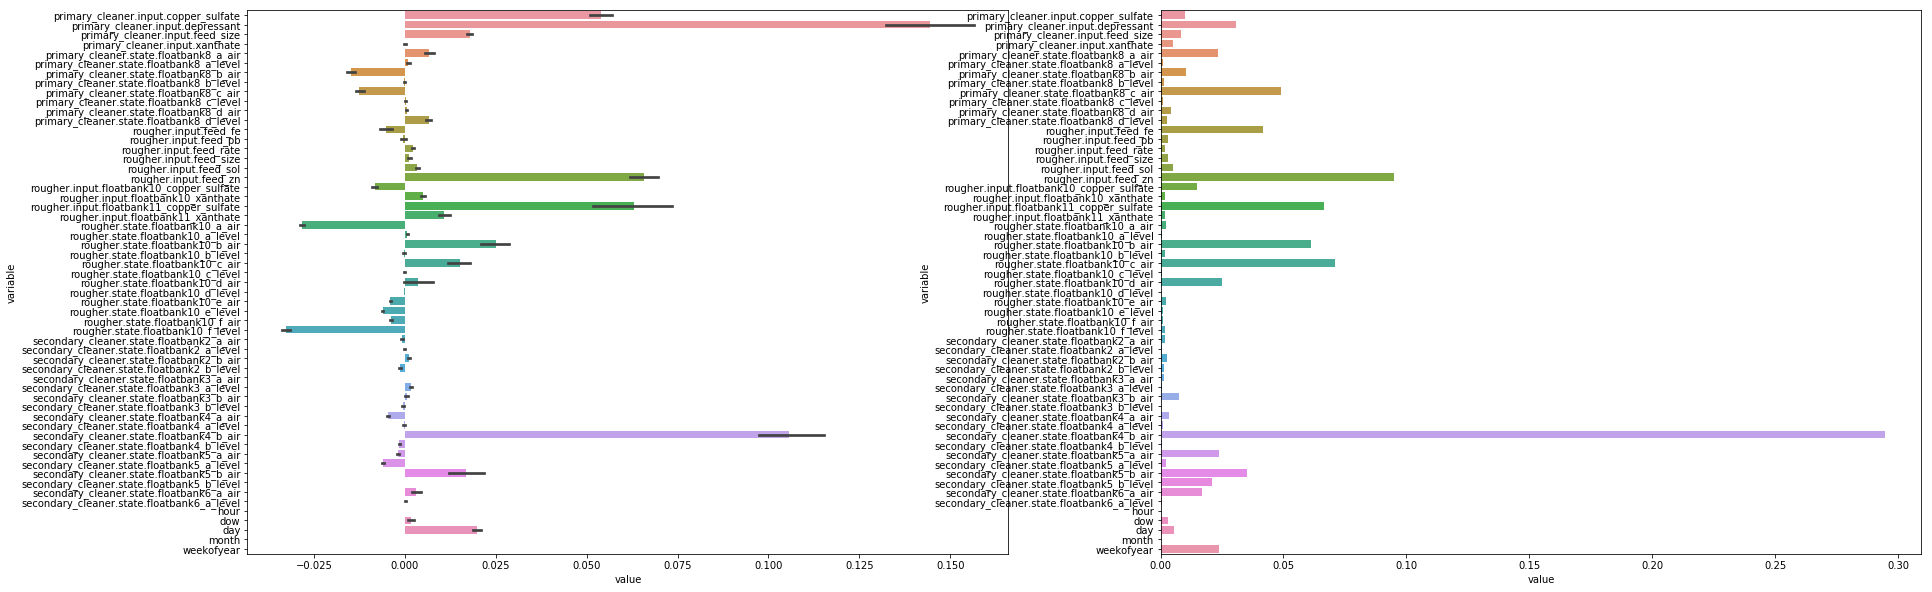

In [25]:

fig,ax = plt.subplots(figsize = (30,10),ncols=2)

feat_df = pd.DataFrame(data=imp_all.T,columns = X_test_raw.columns).reset_index().melt(id_vars = 'index')
feat_df_rf = pd.DataFrame(data={'variable':X_test_raw.columns,'value':rf.feature_importances_})
sns.barplot(data = feat_df,y='variable',x='value',ax =ax[0])
sns.barplot(data = feat_df_rf,y='variable',x='value',ax =ax[1])

In [50]:
feat_df_rf = feat_df_rf.sort_values('value')
feat_sum= feat_df.rename(index=str,columns = {"value":'perm_imp'}).groupby('variable').agg({'perm_imp':np.mean})
feat_df_rf.join(feat_sum).to_csv('feat_imp_rf.csv')


In [101]:
df_raw_feats = pd.read_csv('../data/processed/train_test_raw.csv',parse_dates=['date'])

In [109]:
x = df_raw_feats['date'] - df_raw_feats['date'].shift(1)
x.value_counts()

0 days 01:00:00        22710
122 days 01:00:00          2
243 days 01:00:00          1
0 days 00:59:59            1
-717 days +14:00:00        1
Name: date, dtype: int64

# Test the RollingWindow CV

date
2016-07-11 04:59:59+00:00    56.1618
Name: final.output.recovery, dtype: float64
date
2016-07-19 04:59:59+00:00    75.440777
Name: final.output.recovery, dtype: float64
date
2016-07-28 02:59:59+00:00    100.0
Name: final.output.recovery, dtype: float64
date
2016-08-06 19:59:59+00:00    43.697826
Name: final.output.recovery, dtype: float64
date
2016-08-14 07:59:59+00:00    66.580549
Name: final.output.recovery, dtype: float64
date
2016-08-22 03:59:59+00:00    69.741038
Name: final.output.recovery, dtype: float64
date
2016-08-31 22:59:59+00:00    66.180583
Name: final.output.recovery, dtype: float64


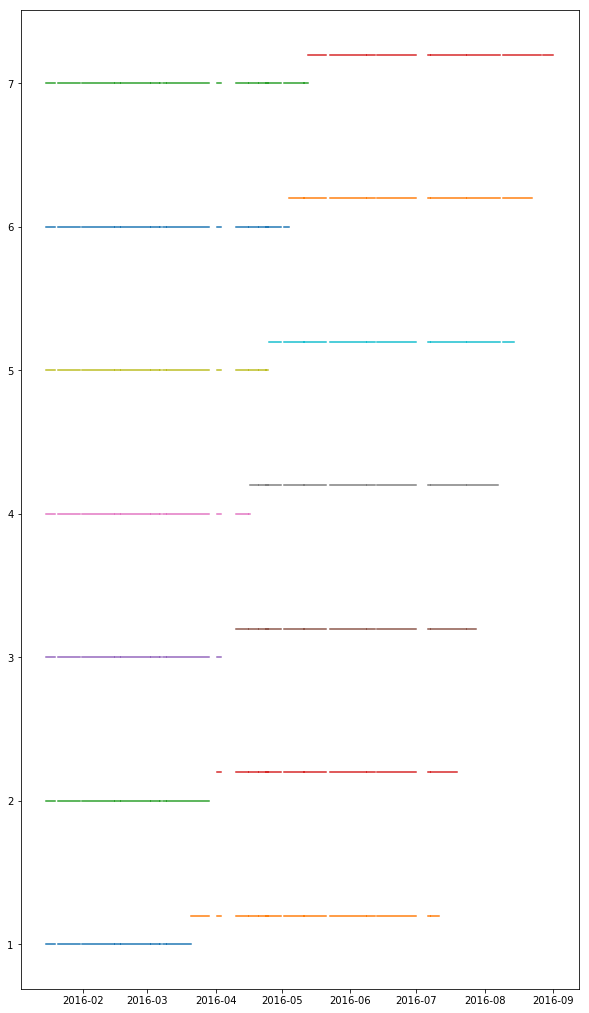

In [14]:
year = 2016
X = data_dict[year]['X_train']
y = data_dict[year]['y_train']['final.output.recovery']
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np
 
class TimeSeriesSplitImproved(TimeSeriesSplit):
    
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=5, test_splits=6):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        fixed_length : bool, hether training sets should always have
            common length
        train_splits : positive int, for the minimum number of
            splits to include in training sets
        test_splits : positive int, for the number of splits to
            include in the test set
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater than the number of samples: {1}.").format(n_folds,n_samples))
        
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)),
                                     test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start],
                       indices[test_start:test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start],
                    indices[test_start:test_start + test_size])
Nmonths_total = 8
Nspl = int(Nmonths_total * 30 / 10)
Nmonths_test = 4
Nmonths_min_train = 2.5
cv_ts = TimeSeriesSplitImproved(n_splits = Nspl)
train_splits = Nspl // Nmonths_total*Nmonths_min_train
test_splits=int(Nmonths_test / Nmonths_total*Nspl)
k=0
tt = pd.DataFrame()
X = X.sample(frac=0.3).sort_index()
y= y[X.index]
fig,ax = plt.subplots(figsize = (10,18))
for n,(train_index, test_index) in enumerate(cv_ts.split(X,fixed_length = False,train_splits = train_splits,test_splits = test_splits )):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(y_test.tail(1))
    k+=1
    ax.plot(y_train.index,(y_train*0+k))                
    ax.plot(y_test.index,(y_test*0+k+0.2))
    #ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


In [13]:
X.index

DatetimeIndex(['2016-01-15 01:00:00+00:00', '2016-01-15 08:00:00+00:00',
               '2016-01-15 09:00:00+00:00', '2016-01-15 11:00:00+00:00',
               '2016-01-15 16:00:00+00:00', '2016-01-15 18:00:00+00:00',
               '2016-01-15 19:00:00+00:00', '2016-01-16 00:00:00+00:00',
               '2016-01-16 02:00:00+00:00', '2016-01-16 05:00:00+00:00',
               ...
               '2016-08-30 01:59:59+00:00', '2016-08-30 02:59:59+00:00',
               '2016-08-30 07:59:59+00:00', '2016-08-30 12:59:59+00:00',
               '2016-08-30 13:59:59+00:00', '2016-08-30 17:59:59+00:00',
               '2016-08-30 21:59:59+00:00', '2016-08-31 07:59:59+00:00',
               '2016-08-31 09:59:59+00:00', '2016-08-31 11:59:59+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=1656, freq=None)

In [76]:
test_splits

24

In [77]:
Nspl


48

In [66]:
8*30/10


24.0

In [ ]:
X.sort()